<a href="https://colab.research.google.com/github/ankita111204/-SpamShield-ML-Email-SMS-Spam-Classifier-/blob/main/detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 📌 Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# 📌 Step 2: Load Dataset
df = pd.read_csv("spam.csv", encoding='latin-1')

# Drop useless columns
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

# Rename useful columns
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

df.head()


,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# 📌 Step 3: Encode Target Labels (ham=0, spam=1)
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

# Remove duplicates
df = df.drop_duplicates(keep='first')

print(df.shape)
df.head()


(5169, 2)


,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


target
0    4516
1     653
Name: count, dtype: int64


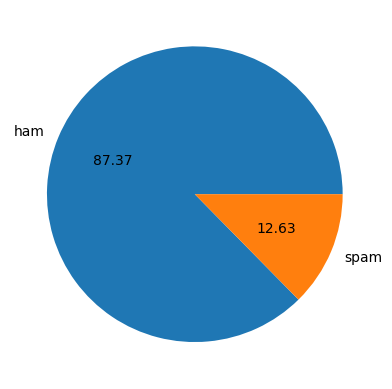

In [4]:
# 📌 Step 4: Exploratory Data Analysis (EDA)

print(df['target'].value_counts())

plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()


In [8]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')   # <-- add this line
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# 📌 Step 5: Feature Engineering
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

df[['num_characters', 'num_words', 'num_sentences']].describe()


,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [10]:
#Step 6: Text Preprocessing (Cleaning + Tokenizing + Stemming)

In [11]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    # keep only alphanumeric words
    y = [i for i in text if i.isalnum()]

    # remove stopwords and punctuation
    y = [i for i in y if i not in stopwords.words('english') and i not in string.punctuation]

    # apply stemming
    y = [ps.stem(i) for i in y]

    return " ".join(y)

# Apply transformation
df['transformed_text'] = df['text'].apply(transform_text)
df.head()


,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


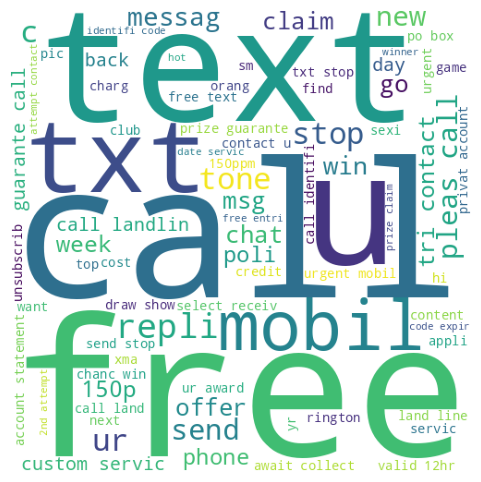

In [12]:
#Step 7: WordCloud for Spam Messages
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(6,6))
plt.imshow(spam_wc)
plt.axis("off")
plt.show()


In [13]:
#Step 8: Most Common Words in Spam & Ham

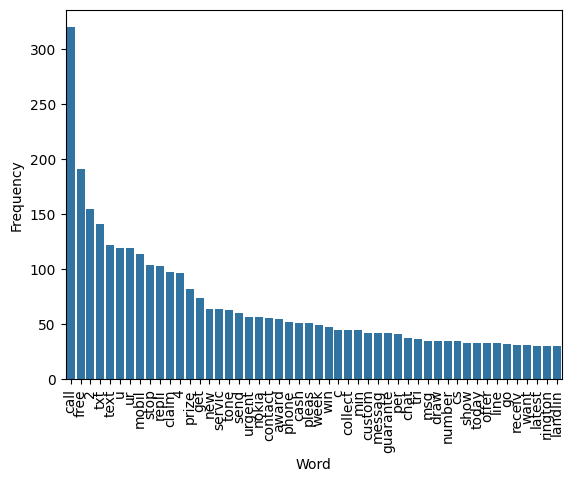

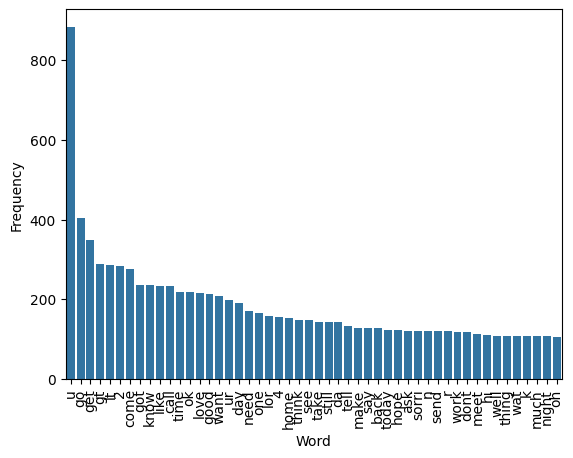

In [14]:
from collections import Counter

# Spam words
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    spam_corpus.extend(msg.split())

spam_df = pd.DataFrame(Counter(spam_corpus).most_common(50), columns=['Word','Frequency'])
sns.barplot(x='Word', y='Frequency', data=spam_df)
plt.xticks(rotation='vertical')
plt.show()

# Ham words
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    ham_corpus.extend(msg.split())

ham_df = pd.DataFrame(Counter(ham_corpus).most_common(50), columns=['Word','Frequency'])
sns.barplot(x='Word', y='Frequency', data=ham_df)
plt.xticks(rotation='vertical')
plt.show()


In [15]:
#Step 9: Feature Extraction (TF-IDF)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()

y = df['target'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [18]:
#Step 10: Model Training
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize models
models = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train & evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"📌 Model: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("="*60)


📌 Model: MultinomialNB
Accuracy: 0.9748549323017408
Confusion Matrix:
 [[901   2]
 [ 24 107]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       903
           1       0.98      0.82      0.89       131

    accuracy                           0.97      1034
   macro avg       0.98      0.91      0.94      1034
weighted avg       0.98      0.97      0.97      1034

📌 Model: BernoulliNB
Accuracy: 0.9835589941972921
Confusion Matrix:
 [[902   1]
 [ 16 115]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       0.99      0.88      0.93       131

    accuracy                           0.98      1034
   macro avg       0.99      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034

📌 Model: Logistic Regression
Accuracy: 0.9555125725338491
Confusion Matrix:
 [[903   0]
 [ 46  85]]
Classificati

In [19]:
#Step 11: Ensemble (Voting Classifier)
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('nb', MultinomialNB()),
        ('svm', SVC(kernel='linear', probability=True))
    ],
    voting='soft'
)

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

print("📌 Ensemble Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


📌 Ensemble Model Performance
Accuracy: 0.9787234042553191
Confusion Matrix:
 [[902   1]
 [ 21 110]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       0.99      0.84      0.91       131

    accuracy                           0.98      1034
   macro avg       0.98      0.92      0.95      1034
weighted avg       0.98      0.98      0.98      1034



In [20]:
#Step 12: Save the Model & Vectorizer
import pickle

pickle.dump(tfidf, open('vectorizer.pkl','wb'))
pickle.dump(ensemble, open('model.pkl','wb'))
